### MACHINE LEARNING PIPELINE - TITANIC

DANIEL CIFUENTES

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
print(str(data.shape))

(891, 12)


In [4]:
#data['Sex'].unique()

In [5]:
#Eliminamos el id de pasajero ya que solo es ruido en la data
data.drop('PassengerId', axis=1, inplace=True)
data.drop('Name', axis=1, inplace=True)

In [6]:
print(str(data.shape))

(891, 10)


### Analisis de Datos

In [7]:
## Analisis de la data
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
data.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object

In [9]:
var_with_na = [var for var in data.columns if(data[var].isnull().sum() > 0)]
len(var_with_na)

3

In [10]:
data[var_with_na].isnull().mean().sort_values(ascending=False)

Cabin       0.771044
Age         0.198653
Embarked    0.002245
dtype: float64

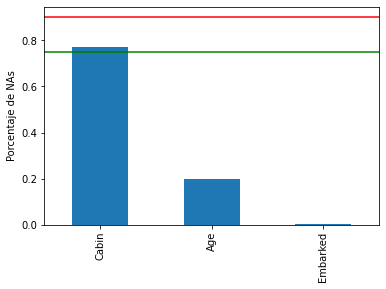

In [11]:
data[var_with_na].isnull().mean().sort_values(ascending=False).plot.bar()
plt.ylabel("Porcentaje de NAs")
plt.axhline(y=0.9, color="r")
plt.axhline(y=0.75, color="g")

In [12]:
def na_impact_over_target(df, Xvar, Yvar):
    df = data.copy()
    df[Xvar] = np.where(df[Xvar].isnull(), 1, 0)
    temp = df.groupby(Xvar)[Yvar].agg(['mean', 'std'])
    temp.plot(kind="barh", y="mean", xerr="std", legend=False, title=Yvar)
    plt.show()

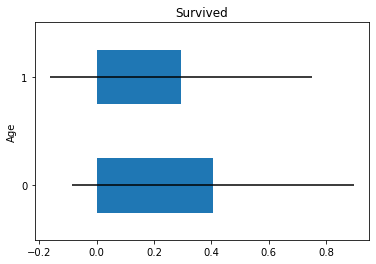

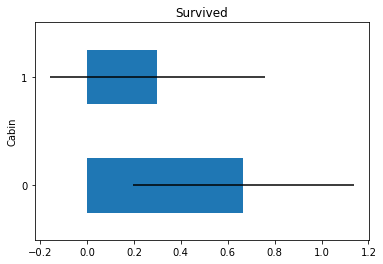

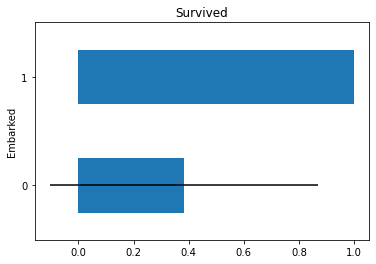

In [13]:
for var in var_with_na:
    na_impact_over_target(data, var, 'Survived')

### Transformacion de Variables

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
                        data.drop(['Survived'], axis=1),
                        data['Survived'],
                        test_size=0.2,
                        random_state=2021)

In [15]:
X_train.shape, X_test.shape

((712, 9), (179, 9))

### Variables Categoricas

In [16]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']
cat_vars = cat_vars + ['Pclass']
cat_vars

['Sex', 'Ticket', 'Cabin', 'Embarked', 'Pclass']

In [17]:
X_train[cat_vars] = X_train[cat_vars].astype('O')
X_test[cat_vars] = X_test[cat_vars].astype('O')

In [18]:
cat_vars_with_na = [var for var in cat_vars 
                        if X_train[var].isnull().sum() > 0]

## Variables Numericas

In [19]:
num_vars = [var for var in X_train.columns
               if var not in cat_vars and var != ('Survived', 'Pclass')]
num_vars

['Age', 'SibSp', 'Parch', 'Fare']

# Tratamiento de Variables con NA

##### Variables Categoricas con NA

In [20]:
cat_vars_with_na

['Cabin', 'Embarked']

In [21]:
X_train[cat_vars_with_na].isnull().mean().sort_values(ascending = False)

Cabin       0.761236
Embarked    0.001404
dtype: float64

Vemos que la variable "Cabin" muestra que más de la mitad de los registros están en blanco, por lo que podemos descartar dicha variable (además que es una variable categórica).

In [22]:
#data.drop('Cabin', axis=1, inplace=True)

In [23]:
#variables tratadas con etiqueta de faltante por cantidad masiva de faltantes.
vars_with_missing_string = [var for var in cat_vars_with_na
                               if X_train[var].isnull().mean() > 0.2]

#variables tratadas con procedimiento por candiad adecuada de faltantes.
vars_freq_category = [var for var in cat_vars_with_na
                               if X_train[var].isnull().mean() <= 0.2]

In [24]:
vars_with_missing_string

['Cabin']

In [25]:
vars_freq_category

['Embarked']

In [26]:
#Faltantes con etiqueta missing
X_train[vars_with_missing_string] = X_train[vars_with_missing_string].fillna('Missing')
X_test[vars_with_missing_string] = X_test[vars_with_missing_string].fillna('Missing')

In [27]:
for var in vars_freq_category:
    mode = X_train[var].mode()[0]
    
    X_train[var].fillna(mode, inplace=True)
    X_test[var].fillna(mode, inplace=True)
    
    print(var, "-------", mode)

Embarked ------- S


In [28]:
X_train[cat_vars_with_na].isnull().mean().sort_values(ascending = False)

Embarked    0.0
Cabin       0.0
dtype: float64

In [29]:
cat_vars_with_na = [var for var in cat_vars 
                        if X_train[var].isnull().sum() > 0]
cat_vars_with_na

[]

#### Variables Numericas con NA

In [30]:
##Numéricas con faltantes
num_vars_with_na = [var for var in num_vars
                       if X_train[var].isnull().sum() > 0]

In [31]:
X_train[num_vars_with_na].isnull().mean()

Age    0.192416
dtype: float64

In [32]:
for var in num_vars_with_na:
    mean_val = X_train[var].mean()
    
    print(var, mean_val)
    
    X_train[var].fillna(mean_val, inplace=True)
    X_test[var].fillna(mean_val, inplace=True)

Age 29.414782608695653


In [33]:
X_train[num_vars_with_na].isnull().mean()

Age    0.0
dtype: float64

### Transformacion Variable de Precio

In [34]:
#Aplicamos transformación logaritmica para el precio
#for var in ['Fare']:
 #   X_train[var] = np.log(X_train[var])
  #  X_test[var] = np.log(X_test[var])

### Codificacion Variables Categoricas

In [35]:
sex_mapping = {'male':1, 'female':2}

var = 'Sex'

X_train[var] = X_train[var].map(sex_mapping)
X_test[var] = X_test[var].map(sex_mapping)

### Codificacion Otras Variables

In [36]:
other_cat = ['Pclass'] + ['SibSp'] + ['Parch'] + ['Ticket'] + ['Embarked'] + ['Cabin']

In [37]:
#funcion para encontar etiquetas raras
def find_rare_labels_freq(df, var, rare_perc):
    temp = df.groupby(var)[var].count()/len(df)
    return temp[temp > rare_perc].index

In [38]:
for var in other_cat:
    freqValue = find_rare_labels_freq(X_train, var, 0.01)
    
    #print(var, '--------', freqValue)
    
    X_train[var] = np.where(X_train[var].isin(freqValue), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(freqValue), X_test[var], 'Rare')

In [39]:
def replace_category_vals(train, test, y_train, var, target):
    
    temp = pd.concat([train, y_train], axis=1) 
    order_labels = temp.groupby([var])[target].mean().sort_values().index
    
    ordinal_values = {k: i for i, k in enumerate(order_labels, 0)}
    
    print(var, ordinal_values)
    
    train[var] = train[var].map(ordinal_values)
    test[var] = test[var].map(ordinal_values)
    

In [40]:
for var in other_cat:
    replace_category_vals(X_train, X_test, y_train, var, 'Survived')

Pclass {3: 0, 2: 1, 1: 2}
SibSp {'Rare': 0, '4': 1, '3': 2, '0': 3, '2': 4, '1': 5}
Parch {'0': 0, 'Rare': 1, '2': 2, '1': 3}
Ticket {'Rare': 0}
Embarked {'S': 0, 'Q': 1, 'C': 2}
Cabin {'Missing': 0, 'Rare': 1}


In [41]:
def analyse_other_cats(train, y_train, var):
    temp = pd.concat([train, y_train], axis=1)

    temp.groupby(var)['Survived'].median().plot.bar()
    plt.title(var)
    plt.ylabel('Survied')
    plt.show()

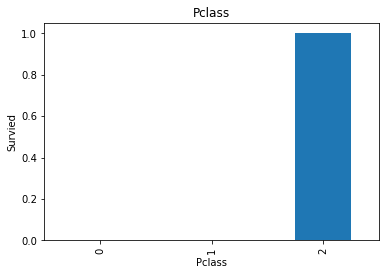

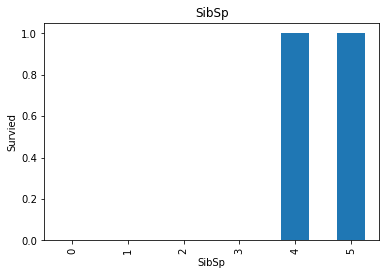

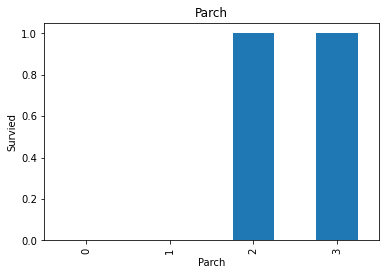

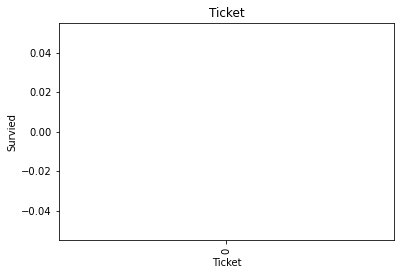

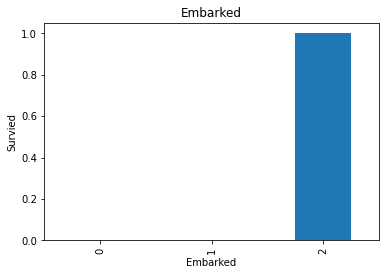

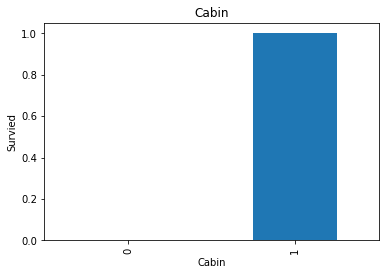

In [42]:
for var in other_cat:
    analyse_other_cats(X_train, y_train, var)

# Construccion de Modelo

In [43]:
### Feature Scaling

In [44]:
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = pd.DataFrame(
    scaler.transform(X_train),
    columns=X_train.columns
)


X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns
)

## Seleccion de Variables

In [45]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [46]:
#objeto selector de variables
sel_ = SelectFromModel(Lasso(alpha=0.001, random_state=0))

sel_.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.001, random_state=0))

In [47]:
sel_.get_support().sum()

7

In [48]:
selected_features = X_train.columns[(sel_.get_support())]

In [49]:
selected_features

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Cabin', 'Embarked'], dtype='object')

### Entrenamiento del Modelo

In [50]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [51]:
linear_model = Lasso(alpha=0.001, random_state=2022)

linear_model.fit(X_train, y_train)

Lasso(alpha=0.001, random_state=2022)

### Predicciones

In [52]:
from sklearn.metrics import mean_squared_error, r2_score

In [53]:
preds_train = linear_model.predict(X_train)

In [54]:
#Resultados del Train
print("MSE de Entrenamiento: {}".format(mean_squared_error(np.exp(y_train), np.exp(preds_train))))

print("RMSE de Entrenamiento: {}".format(mean_squared_error(np.exp(y_train), 
                                                           np.exp(preds_train), squared=False)))

print("R2 de Entrenamiento: {}".format(r2_score(np.exp(y_train), np.exp(preds_train))))

MSE de Entrenamiento: 0.4038870688363235
RMSE de Entrenamiento: 0.6355211002290353
R2 de Entrenamiento: 0.41973916174656123


In [55]:
preds_test = linear_model.predict(X_test)

In [56]:
#Resultados del Test
print("MSE de Entrenamiento: {}".format(mean_squared_error(np.exp(y_test), np.exp(preds_test))))

print("RMSE de Entrenamiento: {}".format(mean_squared_error(np.exp(y_test), 
                                                           np.exp(preds_test), squared=False)))

print("R2 de Entrenamiento: {}".format(r2_score(np.exp(y_test), np.exp(preds_test))))

MSE de Entrenamiento: 0.582413933281535
RMSE de Entrenamiento: 0.7631604898588075
R2 de Entrenamiento: 0.1757348857224269


## 

In [59]:
#import joblib

In [60]:
#joblib.dump(linear_model, 'final_model/lasso_reg.joblib')

# PIPELINE

In [61]:
from sklearn.pipeline import Pipeline

from feature_engine.imputation import(
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder
)

from feature_engine.transformation import LogTransformer

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import my_preprocessors as mypp

ModuleNotFoundError: No module named 'feature_engine'

In [62]:
### Configuracion de Modelo Pipeline